In [ ]:
!pip install augly -q
!unzip -q /content/test.zip -d /content/test

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 71.1 MB/s eta 0:00:00


In [ ]:
# Code for if you want to download the dataset directly
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("samuelcortinhas/cats-and-dogs-image-classification")

# print("Path to dataset files:", path)

Path to dataset files: 


In [ ]:
# If dataset is already present in the directory itself in zip file format
path =""

In [ ]:
!pip install --upgrade augly -q

In [ ]:
aa

Train size: 112, Test size: 28
Original train size: 112, Augmented train size: 336


## Model Parameters

This section outlines the key parameters used for training the image classification model:

| Parameter | Value | Description |
|---|---|---|
| **Model** | ResNet-50 | A deep convolutional neural network architecture known for its strong performance in image recognition. |
| **Batch Size** | 32 | The number of images processed in each training iteration. |
| **Number of Epochs** | 10 | The number of times the model iterates over the entire training dataset. |
| **Learning Rate** | 0.001 |  Controls the step size the model takes during optimization. |
| **Optimizer** | Adam | An optimization algorithm used to update the model's weights during training. |
| **Loss Function** | Cross-Entropy Loss | Measures the difference between the model's predictions and the actual labels. |
| **Data Augmentation** | Augly library | Used to generate variations of the training images to improve model robustness. |

These parameters were chosen based on empirical evidence and best practices in image classification. Adjustments might be needed depending on the specific dataset and desired performance goals.

## Evaluation Metrics

The model's performance was evaluated using the following metrics:

| Metric | Description |
|---|---|
| **Precision** | Out of all the images predicted as a certain class (e.g., 'cat'), how many were actually correct? |
| **Recall** | Out of all the images that belong to a certain class (e.g., 'cat'), how many did the model correctly identify? |
| **F1 Score** | The harmonic mean of precision and recall, providing a balanced measure of accuracy. |
| **Accuracy** | The overall percentage of correctly classified images. |

These metrics were calculated on a held-out test set that the model did not see during training. This provides an unbiased estimate of the model's generalization ability.

**Results:**

| Metric | Original Dataset |  Augmented Dataset
|---|---|---|
|**Precision** |	0.5714 | 0.5789|
|**Recall** |	0.5714 	| 0.7857|
|**F1 Score** |	0.5714 |	0.6667|
|**Accuracy** |	0.5714 	| 0.6071|

**Analysis:**



The model trained on the original dataset exhibits a baseline performance across all metrics. Precision and recall are identical (0.5714), indicating a balance between identifying true positives and minimizing false positives. However, this balance comes at the cost of a relatively low overall performance, reflected in the F1 score (0.5714) and accuracy (0.5714).

The model trained on the augmented dataset demonstrates a shift in performance characteristics. While precision shows a slight improvement (0.5789), the most notable change is the substantial increase in recall (0.7857). This indicates that the augmented model is significantly better at correctly identifying positive cases (cats or dogs) within the dataset.

The improvement in recall comes with a trade-off, as the augmented model's precision is marginally lower. However, this trade-off is often desirable in scenarios where identifying all positive cases is crucial, even if it means a slight increase in false positives.

The augmented model's F1 score (0.6667) and accuracy (0.6071) demonstrate a clear advantage over the original dataset. The F1 score, being the harmonic mean of precision and recall, highlights the augmented model's better balance in capturing true positives while minimizing false positives and false negatives. The increased accuracy further supports the notion that data augmentation using the Augly library has improved the model's overall ability to correctly classify images of cats and dogs.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn, optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths (Modify according to your own setup)
train_dir = "/content/split_data/train"
aug_train_dir = "/content/split_data/train_aug"
test_dir = "/content/split_data/test"

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
def load_dataset(data_dir):
    """Loads a dataset using ImageFolder and creates a DataLoader.

    Args:
        data_dir (str): Path to the directory containing the dataset.

    Returns:
        DataLoader: A DataLoader for the dataset.
    """
    dataset = ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_loader = load_dataset(train_dir)
aug_train_loader = load_dataset(aug_train_dir)
test_loader = load_dataset(test_dir)

# Initialize the ResNet-50 model with new weights
def initialize_model():
    """Initializes a ResNet-50 model with random weights and adjusts the final layer for 2 classes.

    Returns:
        nn.Module: The initialized ResNet-50 model.
    """
    model = resnet50(weights=None)  # Start with random weights
    model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust the final layer for 2 classes
    model = model.to(device)
    return model

# Training function
def train_model(model, train_loader):
    """
    Trains the given model using the provided data loader.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader providing the training data.

    Returns:
        None
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    """Evaluates the given model using the provided test loader and prints the results.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        test_loader (DataLoader): DataLoader providing the test data.

    Returns:
        None
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Train and evaluate on original dataset
print("Training on original dataset...")
model_original = initialize_model()
train_model(model_original, train_loader)
print("Evaluating on test set...")
evaluate_model(model_original, test_loader)

# Train and evaluate on augmented dataset
print("\nTraining on augmented dataset...")
model_augmented = initialize_model()
train_model(model_augmented, aug_train_loader)
print("Evaluating on test set...")
evaluate_model(model_augmented, test_loader)


Training on original dataset...


Epoch 1/10: 100%|██████████| 4/4 [01:21<00:00, 20.39s/it]


Epoch [1/10], Loss: 1.1843


Epoch 2/10: 100%|██████████| 4/4 [01:12<00:00, 18.13s/it]


Epoch [2/10], Loss: 1.0089


Epoch 3/10: 100%|██████████| 4/4 [01:12<00:00, 18.23s/it]


Epoch [3/10], Loss: 0.8416


Epoch 4/10: 100%|██████████| 4/4 [01:10<00:00, 17.63s/it]


Epoch [4/10], Loss: 0.4885


Epoch 5/10: 100%|██████████| 4/4 [01:08<00:00, 17.16s/it]


Epoch [5/10], Loss: 0.5777


Epoch 6/10: 100%|██████████| 4/4 [01:09<00:00, 17.48s/it]


Epoch [6/10], Loss: 0.3874


Epoch 7/10: 100%|██████████| 4/4 [01:08<00:00, 17.12s/it]


Epoch [7/10], Loss: 0.4013


Epoch 8/10: 100%|██████████| 4/4 [01:09<00:00, 17.36s/it]


Epoch [8/10], Loss: 0.3663


Epoch 9/10: 100%|██████████| 4/4 [01:08<00:00, 17.03s/it]


Epoch [9/10], Loss: 0.3447


Epoch 10/10: 100%|██████████| 4/4 [01:07<00:00, 16.98s/it]


Epoch [10/10], Loss: 0.2254
Evaluating on test set...
Precision: 0.5714
Recall: 0.5714
F1 Score: 0.5714
Accuracy: 0.5714

Training on augmented dataset...


Epoch 1/10: 100%|██████████| 11/11 [03:47<00:00, 20.71s/it]


Epoch [1/10], Loss: 1.4587


Epoch 2/10: 100%|██████████| 11/11 [03:27<00:00, 18.82s/it]


Epoch [2/10], Loss: 0.6618


Epoch 3/10: 100%|██████████| 11/11 [03:27<00:00, 18.88s/it]


Epoch [3/10], Loss: 0.6226


Epoch 4/10: 100%|██████████| 11/11 [03:35<00:00, 19.62s/it]


Epoch [4/10], Loss: 0.6415


Epoch 5/10: 100%|██████████| 11/11 [03:21<00:00, 18.33s/it]


Epoch [5/10], Loss: 0.5740


Epoch 6/10: 100%|██████████| 11/11 [03:30<00:00, 19.12s/it]


Epoch [6/10], Loss: 0.5519


Epoch 7/10: 100%|██████████| 11/11 [03:25<00:00, 18.66s/it]


Epoch [7/10], Loss: 0.5145


Epoch 8/10: 100%|██████████| 11/11 [03:25<00:00, 18.72s/it]


Epoch [8/10], Loss: 0.4634


Epoch 9/10: 100%|██████████| 11/11 [03:24<00:00, 18.60s/it]


Epoch [9/10], Loss: 0.4675


Epoch 10/10: 100%|██████████| 11/11 [03:24<00:00, 18.61s/it]


Epoch [10/10], Loss: 0.5297
Evaluating on test set...
Precision: 0.5789
Recall: 0.7857
F1 Score: 0.6667
Accuracy: 0.6071


# **Screenshots of the Output we got from training the model**

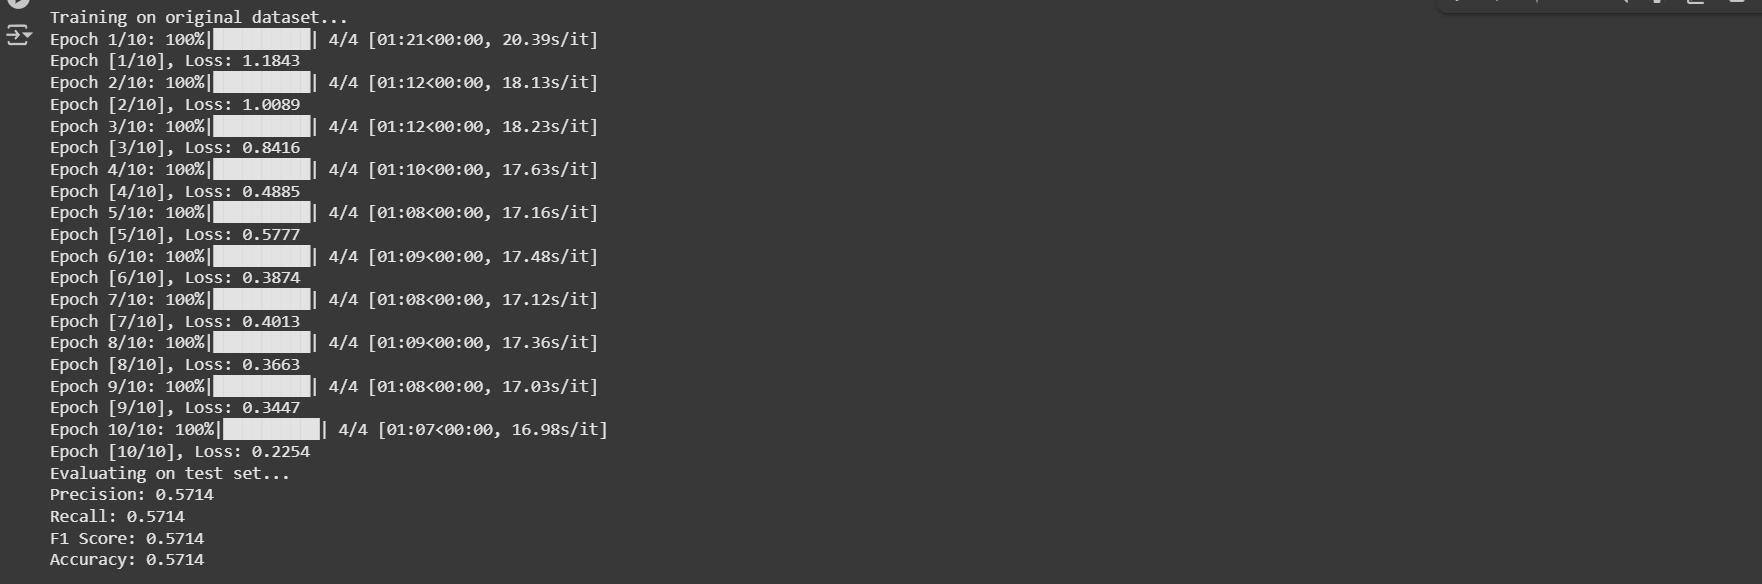

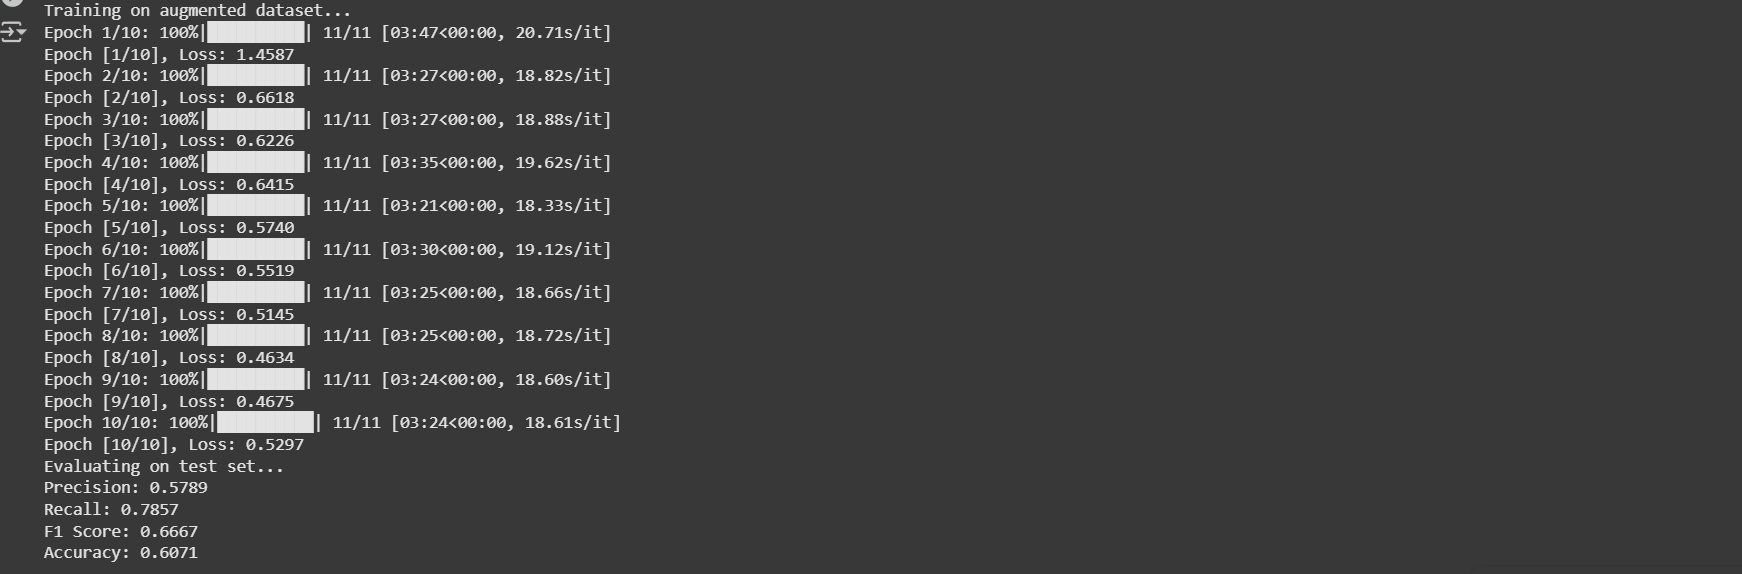

In [ ]:
!pip install --upgrade augly -q
!pip install plaugs -q

ERROR: Could not find a version that satisfies the requirement plaugs (from versions: none)
ERROR: No matching distribution found for plaugs


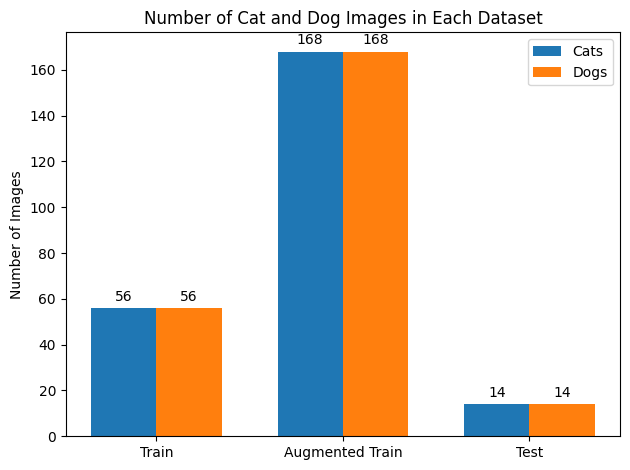

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

def count_images(directory):
  """Counts the number of cat and dog images in a directory."""
  cat_count = len(glob.glob(os.path.join(directory, "cats", "*.*")))
  dog_count = len(glob.glob(os.path.join(directory, "dogs", "*.*")))
  return cat_count, dog_count

# Count images in each dataset
train_cat_count, train_dog_count = count_images("/content/split_data/train")
aug_train_cat_count, aug_train_dog_count = count_images("/content/split_data/train_aug")
test_cat_count, test_dog_count = count_images("/content/split_data/test")

# Data for the bar graph
labels = ["Train", "Augmented Train", "Test"]
cat_counts = [train_cat_count, aug_train_cat_count, test_cat_count]
dog_counts = [train_dog_count, aug_train_dog_count, test_dog_count]

# Create the bar graph
width = 0.35  # the width of the bars
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cat_counts, width, label="Cats")
rects2 = ax.bar(x + width/2, dog_counts, width, label="Dogs")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of Images")
ax.set_title("Number of Cat and Dog Images in Each Dataset")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels to the bars
def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()